## Load Libraries

In [ ]:
import seaborn as sns
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import urllib.request

In [ ]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=262633bef2fd9a95c507e330309d8730e4d4a5f89e933f879edc7832383f3c8d
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
# Check GPU
!nvidia-smi

Mon Apr  7 23:23:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install -q tensorflow tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 29.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/images_resized.zip'
extract_path = '/content/chest_xray_images'

In [ ]:
!unzip -q "$zip_path" -d "$extract_path"

replace /content/chest_xray_images/images_resized/00014178_001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
# import zipfile
# import time

# start = time.time()
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)
# end = time.time()

# print(f"Extraction completed in {(end - start) / 60:.2f} minutes")

In [ ]:
import os

# Preview a few image filenames
os.listdir(extract_path)[:10]

['images_resized']

In [ ]:
# prompt: Count the number of files in 'images_resized' under extract_path

import os

# Assuming extract_path is defined as in your previous code
extract_path = '/content/chest_xray_images'
image_dir = os.path.join(extract_path, 'images_resized')

# Check if the directory exists
if os.path.exists(image_dir):
    num_files = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])
    print(f"Number of files in 'images_resized': {num_files}")
else:
    print(f"Directory 'images_resized' not found in '{extract_path}'")


Number of files in 'images_resized': 38008


## Load Dataset

In [ ]:
# Set the dataset path
dataset_name = "nih-chest-xrays/data"
version = 3
# Set the path to the file you'd like to load
file_path = "Data_Entry_2017.csv"
file_path_bbox = "BBox_List_2017.csv"

gcloud_url_base = 'https://storage.googleapis.com/gcs-public-data--healthcare-nih-chest-xray/png/'

In [ ]:
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_box_list = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path_bbox
)

<ipython-input-25-1e51267dc0e1>:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
<ipython-input-25-1e51267dc0e1>:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_box_list = kagglehub.load_dataset(


In [74]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38008 entries, 0 to 38007
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Image Index      38008 non-null  object 
 1   Finding Labels   38008 non-null  object 
 2   Follow-up #      38008 non-null  int64  
 3   Patient ID       38008 non-null  int64  
 4   Patient Age      38008 non-null  int64  
 5   Patient Gender   38008 non-null  object 
 6   View Position    38008 non-null  object 
 7   width            38008 non-null  int64  
 8   height           38008 non-null  int64  
 9   pixel_spacing x  38008 non-null  float64
 10  pixel_spacing y  38008 non-null  float64
 11  encoded_labels   38008 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 3.5+ MB


None

# Remove all where "View Position" column value is "AP"
AP means "anteroposterior dimension" which is an X-ray from front-to-back This wil affect the training with both back-to-front and front-to-back images of MRIs

In [ ]:
# Entries before removal
print(f"Before 'AP' removal: {df['View Position'].value_counts()}")

# Entries after removal
df = df[df['View Position'] != 'AP']

# Remaining data is 66.57% of total initial data
print(f"After 'AP' removal: {df['View Position'].value_counts()}")

Before 'AP' removal: View Position
PA    67310
AP    44810
Name: count, dtype: int64
After 'AP' removal: View Position
PA    67310
Name: count, dtype: int64


In [ ]:
links = [
    "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz",
    "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz",
    "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz",
    "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz",
    "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz",
    "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz",
    "https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz",
    "https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz",
    "https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz",
    "https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz",
    "https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz",
    "https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz",
]

In [ ]:
# Create a dictionary for folder locations
folder_ranges = {
    "images_001": (0, 4998),  # Adjusted to 0-based index
    "images_002": (4999, 14998),
    "images_003": (14999, 24998),
    "images_004": (24999, 34998),
    "images_005": (34999, 44998),
    "images_006": (44999, 54998),
    "images_007": (54999, 64998),
    "images_008": (64999, 74998),
    "images_009": (74999, 84998),
    "images_010": (84999, 94998),
    "images_011": (94999, 104998),
    "images_012": (104999, 112120)
}

def get_image_folder(df, image_name):
    if image_name in df["Image Index"].values:
        image_index = df[df["Image Index"] == image_name].index[0]  # Get row index
        # print(f"Image {image_name} is at index {image_index}")  # Debugging output

        for folder, (start, end) in folder_ranges.items():
            if start <= image_index <= end:
                return folder

    return None  # If not found

In [ ]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

# We want to have 7 generalized classes from the original 15
Take values from "Finding Labels" and convert them into more generalized labels

In [ ]:
# Create a list to store all unique labels
all_labels = []

# Iterate over the 'Finding Labels' column
for index, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        all_labels.append(label)

# Get unique labels and print them
all_labels = list(set(all_labels))
print(f"All possible options in 'Finding Labels': {all_labels}")

All possible options in 'Finding Labels': ['Edema', 'Hernia', 'Cardiomegaly', 'Pneumothorax', 'No Finding', 'Infiltration', 'Fibrosis', 'Pneumonia', 'Consolidation', 'Nodule', 'Emphysema', 'Pleural_Thickening', 'Effusion', 'Mass', 'Atelectasis']


In [ ]:
def generalize_labels(label):
    if label in ['Pneumonia', 'Consolidation', 'Infiltration']:
        return 'Infection/Infiltration'
    elif label in ['Edema', 'Effusion', 'Pleural_Thickening']:
        return 'Fluid Related Issues'
    elif label in ['Atelectasis', 'Pneumothorax', 'Fibrosis', 'Emphysema']:
        return 'Lung Structure Issues'
    elif label in ['Nodule', 'Mass']:
        return 'Nodule/Mass'
    elif label == 'Cardiomegaly':
        return 'Cardiac Issues'
    elif label == 'Hernia':
        return 'Hernia'
    else:
        return label  # If we don't detect an issue 'No Finding'


df['Finding Labels'] = df['Finding Labels'].apply(lambda x: '|'.join([generalize_labels(label) for label in x.split('|')]))

# Example:
display(df.head()) # View the updated DataFrame

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
display(df.describe())
display(df.info())

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,0.0
mean,4.786317,14396.542802,47.352979,2632.590016,2652.208468,0.153868,0.153868,NaN
std,9.403191,8559.885944,16.289550,374.573816,396.607849,0.017179,0.017179,NaN
min,0.000000,1.000000,1.000000,1143.000000,1001.000000,0.115000,0.115000,NaN
25%,0.000000,7157.250000,36.000000,2500.000000,2411.000000,0.143000,0.143000,NaN
50%,1.000000,14112.000000,49.000000,2678.000000,2885.000000,0.143000,0.143000,NaN
75%,5.000000,21117.750000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,156.000000,30805.000000,412.000000,3056.000000,3056.000000,0.194336,0.194336,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 67310 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  67310 non-null  object 
 1   Finding Labels               67310 non-null  object 
 2   Follow-up #                  67310 non-null  int64  
 3   Patient ID                   67310 non-null  int64  
 4   Patient Age                  67310 non-null  int64  
 5   Patient Gender               67310 non-null  object 
 6   View Position                67310 non-null  object 
 7   OriginalImage[Width          67310 non-null  int64  
 8   Height]                      67310 non-null  int64  
 9   OriginalImagePixelSpacing[x  67310 non-null  float64
 10  y]                           67310 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


None

In [ ]:
# # Fix column names
# df_box_list = df_box_list.rename(columns={'Bbox [x': 'x', 'h]': 'h'})
# df_box_list.head()

In [ ]:
df['Finding Labels'].info()
df['Finding Labels'].head()

<class 'pandas.core.series.Series'>
Index: 67310 entries, 0 to 112119
Series name: Finding Labels
Non-Null Count  Dtype 
--------------  ----- 
67310 non-null  object
dtypes: object(1)
memory usage: 1.0+ MB


,Finding Labels
0,Cardiac Issues
1,Cardiac Issues|Lung Structure Issues
2,Cardiac Issues|Fluid Related Issues
3,No Finding
4,Hernia


In [ ]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


# Pre-processing - Image Scaling


In [ ]:
# Reduce rows with 'No Finding' label to a maximum of 10,000
no_finding_df = df[df['Finding Labels'] == 'No Finding']
if len(no_finding_df) > 10000:
    no_finding_df = no_finding_df.sample(n=10000, random_state=42)  # Randomly sample 10,000 rows

# Concatenate the reduced 'No Finding' rows with other rows
other_findings_df = df[df['Finding Labels'] != 'No Finding']
df = pd.concat([no_finding_df, other_findings_df], ignore_index=True)

In [ ]:
len(df)

38008

In [ ]:
import os

image_files = set(os.listdir('/content/chest_xray_images/images_resized'))
missing_files = df[~df['Image Index'].isin(image_files)]
print("Number of missing images:", len(missing_files))


Number of missing images: 0


In [ ]:
# Rename columns
df = df.rename(columns={
    "OriginalImage[Width": "width",
    "Height]": "height",
    "OriginalImagePixelSpacing[x": "pixel_spacing x",
    "y]": "pixel_spacing y"
})

display(df.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,Unnamed: 11,encoded_labels
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143,NaN,"[0, 0, 0, 0, 0, 1, 0]"
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171,NaN,"[0, 0, 0, 0, 0, 1, 0]"
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168,NaN,"[0, 0, 0, 0, 0, 1, 0]"
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168,NaN,"[0, 0, 0, 0, 0, 1, 0]"
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143,NaN,"[0, 0, 0, 0, 0, 1, 0]"


In [ ]:
# drop 'Unnamed: 11' column
df = df.drop(columns=['Unnamed: 11'], errors='ignore')
display(df.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,encoded_labels
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171,"[0, 0, 0, 0, 0, 1, 0]"
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"


In [ ]:
# Extract all unique labels
all_labels = sorted(set(label for sublist in df['Finding Labels'].str.split('|') for label in sublist))
display(all_labels)

# Encode multi-labels
def encode_multilabel(labels):
    label_set = labels.split('|')
    return [1 if label in label_set else 0 for label in all_labels]

df['encoded_labels'] = df['Finding Labels'].apply(encode_multilabel)
display(df.head())

y = np.array(df['encoded_labels'].tolist())

['Cardiac Issues',
 'Fluid Related Issues',
 'Hernia',
 'Infection/Infiltration',
 'Lung Structure Issues',
 'No Finding',
 'Nodule/Mass']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,encoded_labels
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171,"[0, 0, 0, 0, 0, 1, 0]"
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"


# TensorFlow Data Generator

In [ ]:
import tensorflow as tf
import os
import numpy as np

# Define constants
IMG_SIZE = 512  # You can change this if needed (e.g., 1024)
BATCH_SIZE = 8
IMAGE_PATH = '/content/chest_xray_images/images_resized'

# Function to load and preprocess an image
def load_image(image_id):
    # Construct full path
    image_path = os.path.join(IMAGE_PATH, image_id.numpy().decode('utf-8'))
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # For JPEG; adjust if your images are PNG
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalize pixels
    return image

# Parsing function for tf.data.Dataset
def parse_function(filename, label):
    image = tf.py_function(func=load_image, inp=[filename], Tout=tf.float32)
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return image, label

# Extract filenames and labels from your DataFrame
image_filenames = df['Image Index'].values
labels = np.array(df['encoded_labels'].tolist(), dtype=np.float32)

# Build the dataset
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, labels))
dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Train/Test Split

In [ ]:
trainval_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(trainval_df, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split

# train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Build datasets for training and validation
def build_dataset_from_df(dataframe):
    filenames = dataframe['Image Index'].values
    labels = np.array(dataframe['encoded_labels'].tolist(), dtype=np.float32)
    ds = tf.data.Dataset.from_tensor_slices((filenames, labels))
    ds = ds.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = build_dataset_from_df(train_df)
val_dataset = build_dataset_from_df(val_df)
test_dataset = build_dataset_from_df(test_df)

# Fine-Tuning EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy

NUM_CLASSES = 7  # Number of classes

# Load base model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Initially freeze the base_model

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[BinaryAccuracy()])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 16, 16, 1280)        │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Training (10 Epochs)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 206s 53ms/step - binary_accuracy: 0.8139 - loss: 0.4385 - val_binary_accuracy: 0.8156 - val_loss: 0.4283
Epoch 2/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 157s 45ms/step - binary_accuracy: 0.8147 - loss: 0.4353 - val_binary_accuracy: 0.8156 - val_loss: 0.4283
Epoch 3/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 157s 45ms/step - binary_accuracy: 0.8146 - loss: 0.4350 - val_binary_accuracy: 0.8156 - val_loss: 0.4290
Epoch 4/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 156s 44ms/step - binary_accuracy: 0.8149 - loss: 0.4353 - val_binary_accuracy: 0.8156 - val_loss: 0.4285
Epoch 5/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 156s 44ms/step - binary_accuracy: 0.8149 - loss: 0.4343 - val_binary_accuracy: 0.8156 - val_loss: 0.4273
Epoch 6/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 157s 45ms/step - binary_accuracy: 0.8147 - loss: 0.4346 - val_binary_accuracy: 0.8156 - val_loss: 0.4322
Epoch 7/10
3421/3421 ━━━━━━━━━━━━━━━━━━━━ 161s 46ms/step - binary_accuracy: 0.8150 - loss: 0.4361 - val_binary_accurac

In [ ]:
print(history.history.keys())

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


# Manually Test Predictions on Test Data


In [78]:
# Grab a batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)

    # Print the first 5 predictions vs actual labels
    for i in range(8):
        print(f"Actual:     {labels[i].numpy().round(2)}")
        print(f"Predicted:  {predictions[i].round(2)}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]

Actual:     [0. 0. 0. 0. 0. 0. 1.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]

Actual:     [0. 0. 0. 1. 1. 0. 0.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]

Actual:     [0. 0. 0. 1. 0. 0. 0.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]

Actual:     [0. 0. 0. 0. 1. 0. 0.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]

Actual:     [0. 0. 0. 0. 0. 1. 0.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]

Actual:     [0. 1. 0. 0. 1. 0. 0.]
Predicted:  [0.06 0.19 0.   0.3  0.33 0.23 0.22]



# Plot Training Curves (Accuracy/Loss)

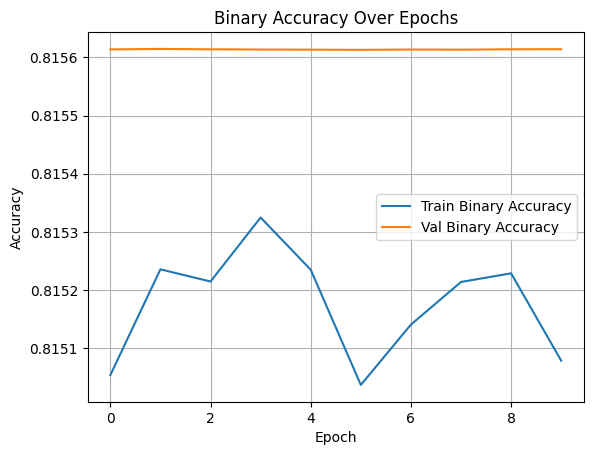

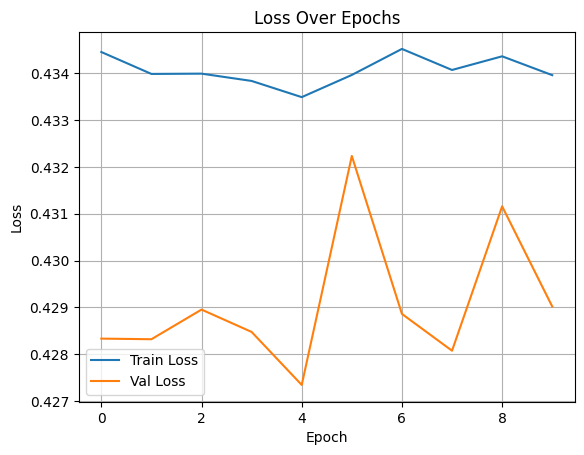

In [ ]:
import matplotlib.pyplot as plt

# Plot binary accuracy
plt.plot(history.history['binary_accuracy'], label='Train Binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Binary Accuracy')
plt.title('Binary Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluate on Test Set

In [ ]:
test_loss, test_binary_accuracy = model.evaluate(test_dataset)
print(f"\nTest Binary Accuracy: {test_binary_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

476/476 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - binary_accuracy: 0.8127 - loss: 0.4345

Test Binary Accuracy: 0.8148
Test Loss: 0.4314


# Per-Class Performance (Precision/Recall)


In [ ]:
from sklearn.metrics import classification_report

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int))  # Threshold at 0.5

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
print(classification_report(y_true, y_pred, target_names=all_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


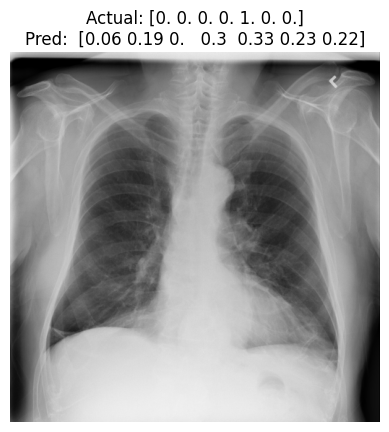

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


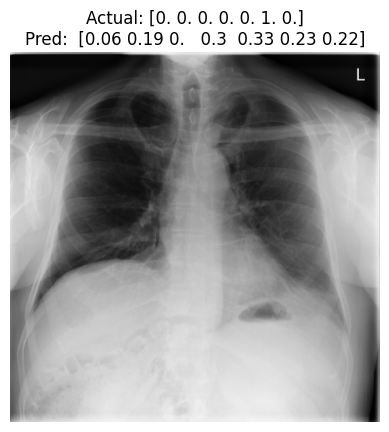

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


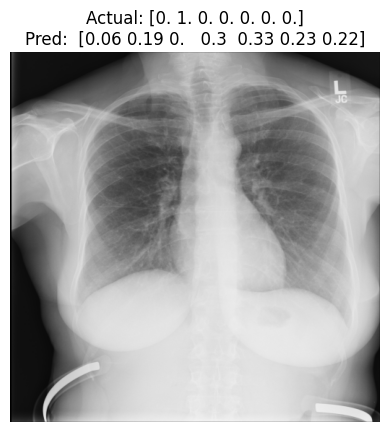

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


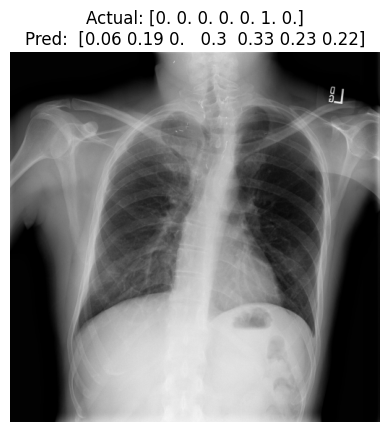

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


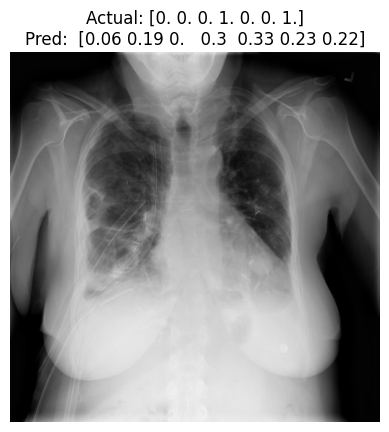

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


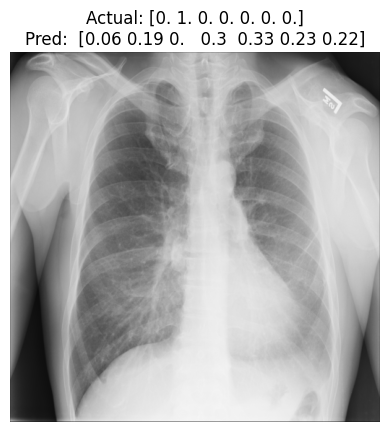

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


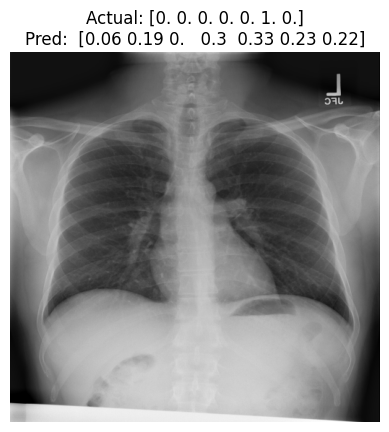

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


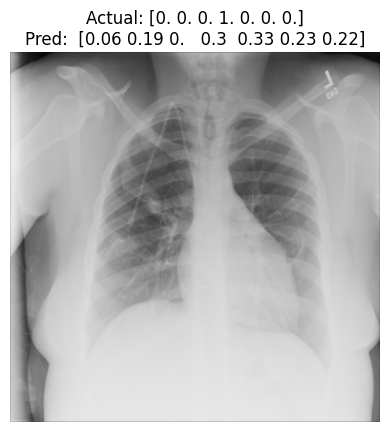

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [79]:
import matplotlib.pyplot as plt

# Show actual image content + prediction
for img_batch, label_batch in test_dataset.take(1):
    for i in range(10):
        img = img_batch[i].numpy()
        label = label_batch[i].numpy()
        pred = model.predict(tf.expand_dims(img, axis=0))[0]

        plt.imshow(img)
        plt.title(f"Actual: {label}\nPred:  {np.round(pred, 2)}")
        plt.axis('off')
        plt.show()

In [80]:
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        print(layer.get_weights())

[array([[-0.15821423, -0.19162193, -0.02268133, ..., -0.00020346,
         0.08569334, -0.18609829],
       [ 0.03601435,  0.03829023,  0.04720568, ...,  0.09879349,
        -0.12969258,  0.0722261 ],
       [-0.04618679,  0.0482053 ,  0.16460878, ...,  0.05681115,
        -0.03685991, -0.05202927],
       ...,
       [-0.09491635, -0.0427932 , -0.07238369, ..., -0.03297503,
         0.01786666,  0.0029539 ],
       [-0.02404725, -0.05737611,  0.11355923, ...,  0.00541141,
         0.10088314, -0.08804408],
       [ 0.02356225,  0.04647821,  0.20133413, ...,  0.02582014,
         0.03821019,  0.00664525]], dtype=float32), array([-0.19187073, -0.14054905, -0.16375318, -0.09539691, -0.1152894 ,
       -0.12676008, -0.16194436], dtype=float32)]


In [81]:
from sklearn.metrics import classification_report
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = np.vstack([y for _, y in test_dataset])
print(classification_report(y_true, y_pred, target_names=all_labels))

476/476 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step
                        precision    recall  f1-score   support

        Cardiac Issues       0.00      0.00      0.00       155
  Fluid Related Issues       0.00      0.00      0.00       881
                Hernia       0.00      0.00      0.00        21
Infection/Infiltration       0.00      0.00      0.00      1062
 Lung Structure Issues       0.00      0.00      0.00      1066
            No Finding       0.00      0.00      0.00      1015
           Nodule/Mass       0.00      0.00      0.00       727

             micro avg       0.00      0.00      0.00      4927
             macro avg       0.00      0.00      0.00      4927
          weighted avg       0.00      0.00      0.00      4927
           samples avg       0.00      0.00      0.00      4927



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
